In [ ]:
# Install the necessary packages
!pip install catboost dask[dataframe] xgboost lightgbm seaborn matplotlib scikit-learn imbalanced-learn statsmodels scipy

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 16.2 MB/s eta 0:00:00


In [ ]:
# Step 2: Import Libraries
print("Step 2: Importing Libraries")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, VotingClassifier)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (accuracy_score, precision_score, f1_score, recall_score, roc_curve, auc, confusion_matrix)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from scipy.stats import chi2_contingency, fisher_exact


Step 2: Importing Libraries


In [ ]:
# Step 3: Load Dataset
print("Step 3: Loading Dataset")
df = pd.read_csv('/content/heart_statlog_cleveland_hungary_final.csv')
print("Dataset Loaded: ")
print(df.head())  # Print the first few rows of the dataset to verify


Step 3: Loading Dataset
Dataset Loaded: 
   age  sex  chest pain type  resting bp s  cholesterol  fasting blood sugar  \
0   40    1                2           140          289                    0   
1   49    0                3           160          180                    0   
2   37    1                2           130          283                    0   
3   48    0                4           138          214                    0   
4   54    1                3           150          195                    0   

   resting ecg  max heart rate  exercise angina  oldpeak  ST slope  target  
0            0             172                0      0.0         1       0  
1            0             156                0      1.0         2       1  
2            1              98                0      0.0         1       0  
3            0             108                1      1.5         2       1  
4            0             122                0      0.0         1       0  


In [ ]:
# Step 4: Handle Missing/Null Values
print("Step 4: Handling Missing/Null Values")
for column in df.columns:
    if df[column].dtype == 'object':  # Categorical
        df[column] = df[column].fillna(df[column].mode()[0])
    else:  # Numerical
        if df[column].skew() > 1:  # Outliers exist
            df[column] = df[column].fillna(df[column].median())
        else:
            df[column] = df[column].fillna(df[column].mean())

print("Null values handled:")
print(df.isnull().sum())  # Print to verify that there are no missing values left


Step 4: Handling Missing/Null Values
Null values handled:
age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
target                 0
dtype: int64


In [ ]:
# Step 5: Feature Encoding
print("Step 5: Feature Encoding")
label_encoder = LabelEncoder()

# Apply Label Encoding to categorical features
df['resting ecg'] = label_encoder.fit_transform(df['resting ecg'])
df['chest pain type'] = label_encoder.fit_transform(df['chest pain type'])
df['ST slope'] = label_encoder.fit_transform(df['ST slope'])
df['fasting blood sugar'] = label_encoder.fit_transform(df['fasting blood sugar'])
df['sex'] = label_encoder.fit_transform(df['sex'])  # Encoding for 'sex'
df['exercise angina'] = label_encoder.fit_transform(df['exercise angina'])  # Encoding for 'exercise angina'

print("Label Encoding Completed for categorical features:")
print(df[['resting ecg', 'chest pain type', 'ST slope', 'fasting blood sugar', 'sex', 'exercise angina']].head())


Step 5: Feature Encoding
Label Encoding Completed for categorical features:
   resting ecg  chest pain type  ST slope  fasting blood sugar  sex  \
0            0                1         1                    0    1   
1            0                2         2                    0    0   
2            1                1         1                    0    1   
3            0                3         2                    0    0   
4            0                2         1                    0    1   

   exercise angina  
0                0  
1                0  
2                0  
3                1  
4                0  


Step 6: Exploratory Data Analysis (EDA)
Performing Pairplot EDA


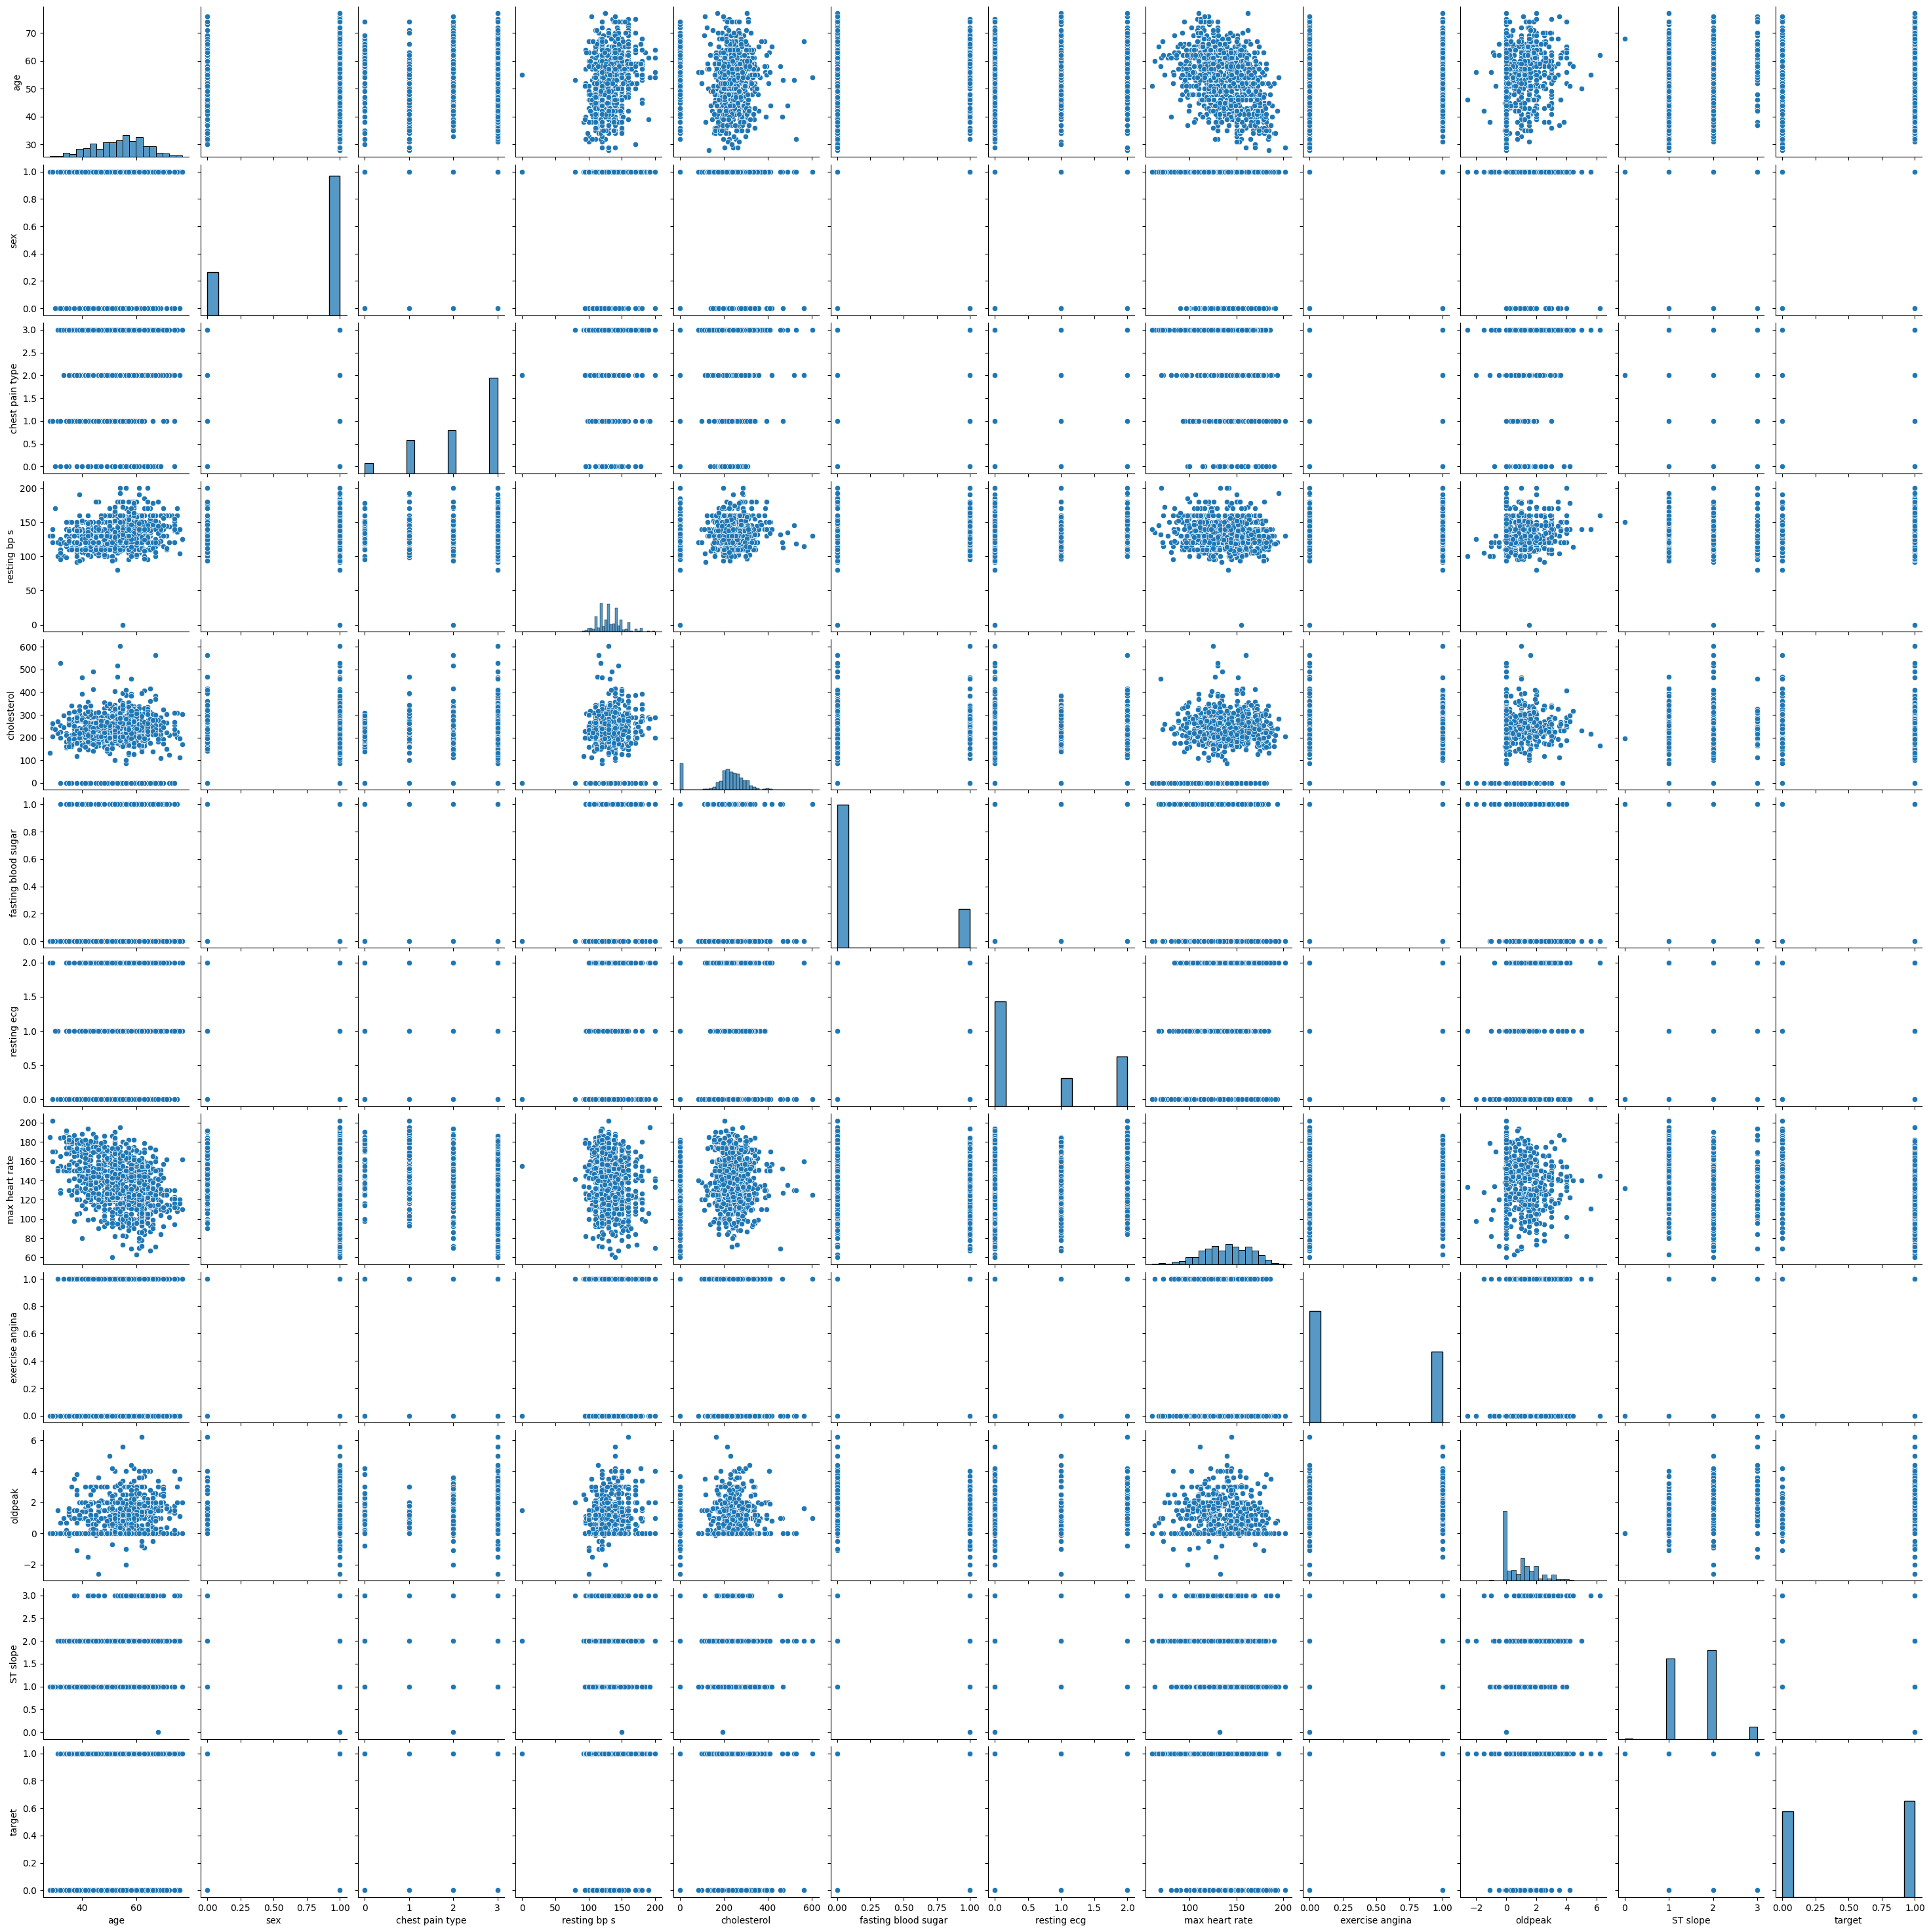

Correlation Heatmap EDA


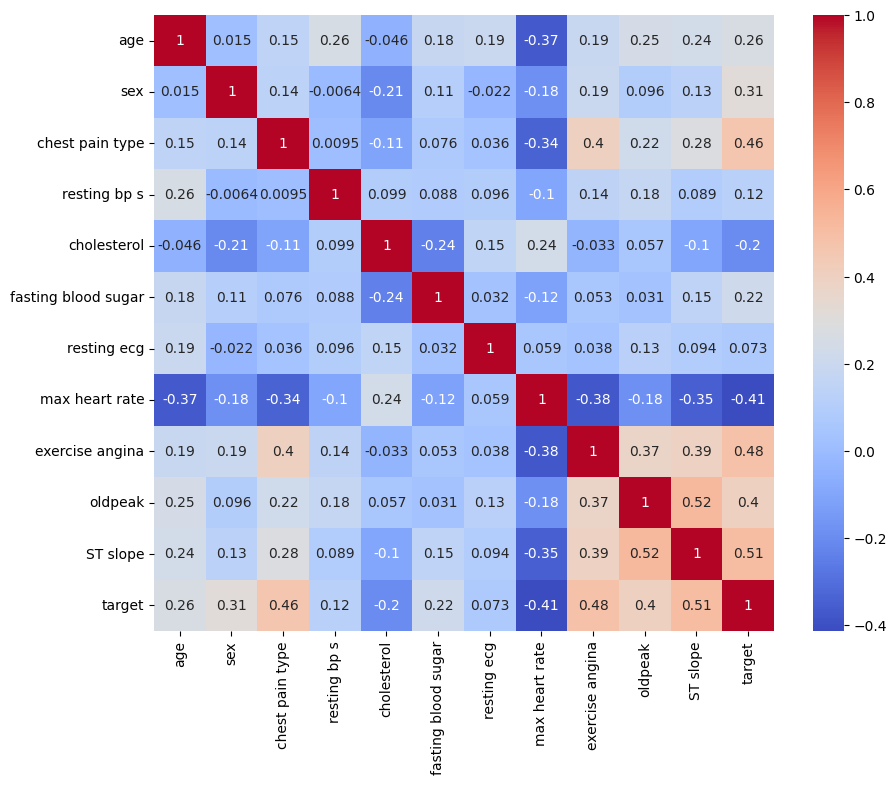

In [ ]:
# Step 6: Exploratory Data Analysis (EDA)
print("Step 6: Exploratory Data Analysis (EDA)")

# Pairplot
print("Performing Pairplot EDA")
sns.pairplot(df)
plt.show()

# Correlation Heatmap
print("Correlation Heatmap EDA")
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()


In [ ]:
# Step 7: Calculate Correlation with Target Variable
print("Step 7: Calculating Correlation with Target Variable")
correlation_matrix = df.corr()
correlation_with_target = correlation_matrix['target'].sort_values(ascending=False)
print("Correlation with Target Variable:")
print(correlation_with_target)


Step 7: Calculating Correlation with Target Variable
Correlation with Target Variable:
target                 1.000000
ST slope               0.505608
exercise angina        0.481467
chest pain type        0.460127
oldpeak                0.398385
sex                    0.311267
age                    0.262029
fasting blood sugar    0.216695
resting bp s           0.121415
resting ecg            0.073059
cholesterol           -0.198366
max heart rate        -0.413278
Name: target, dtype: float64


Step 8: Visualizing Correlation with Target Variable


<ipython-input-8-258bcaf14994>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values, palette='viridis')


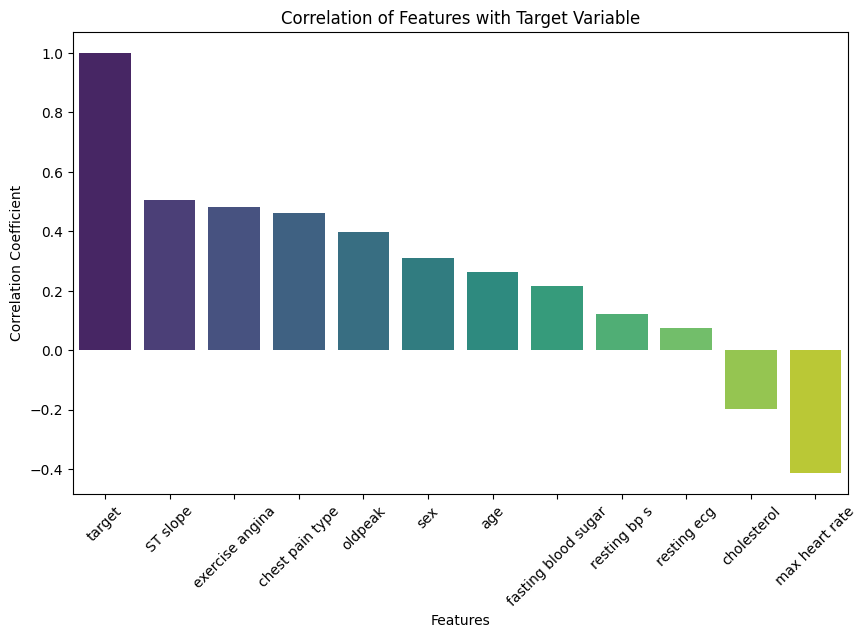

In [ ]:
# Step 8: Visualize Correlation with Target Variable
print("Step 8: Visualizing Correlation with Target Variable")
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values, palette='viridis')
plt.title('Correlation of Features with Target Variable')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.show()


Step 9: Creating Density Plot for Individual Numerical Features
Density Plot for age


<ipython-input-9-1c7844c87c40>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[feature], shade=True)


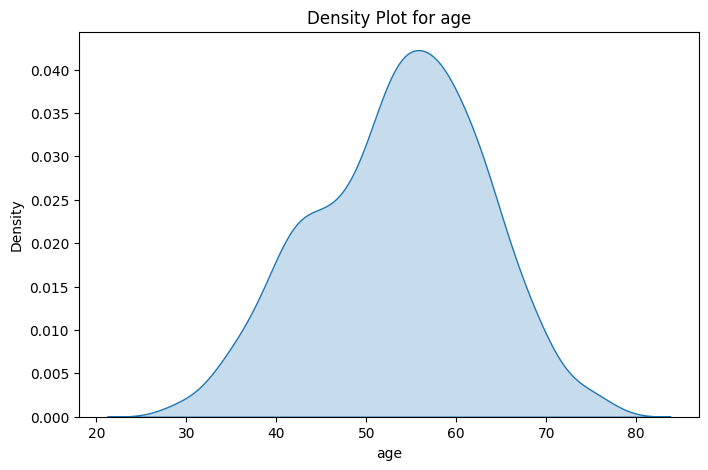

Density Plot for resting bp s


<ipython-input-9-1c7844c87c40>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[feature], shade=True)


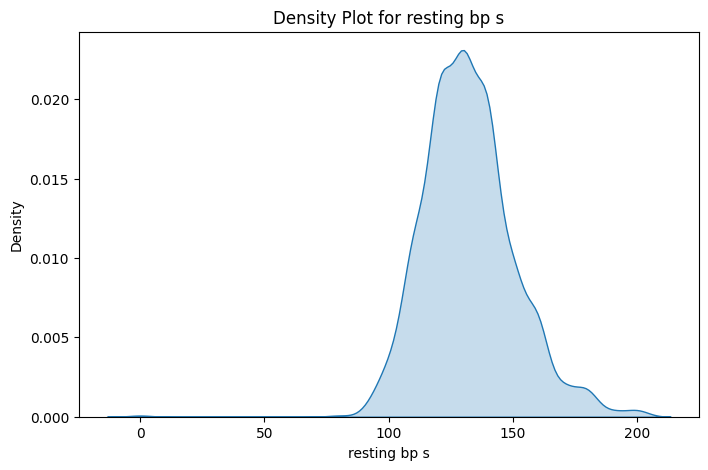

Density Plot for cholesterol


<ipython-input-9-1c7844c87c40>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[feature], shade=True)


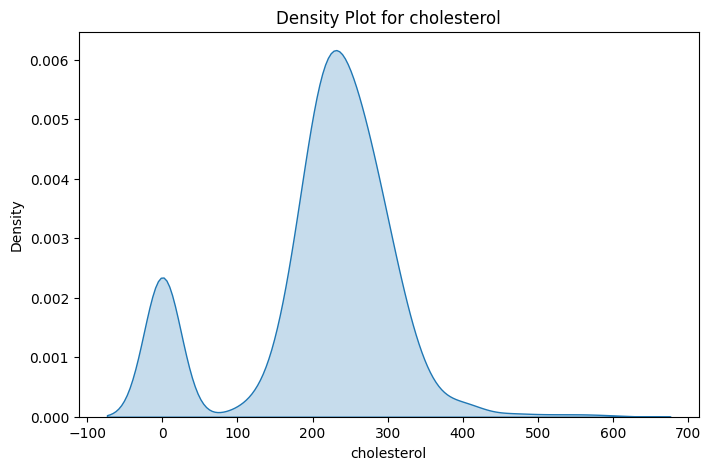

Density Plot for max heart rate


<ipython-input-9-1c7844c87c40>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[feature], shade=True)


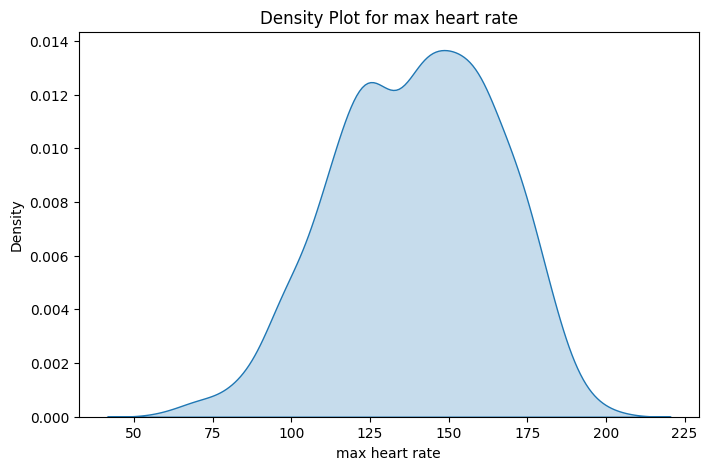

Density Plot for oldpeak


<ipython-input-9-1c7844c87c40>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[feature], shade=True)


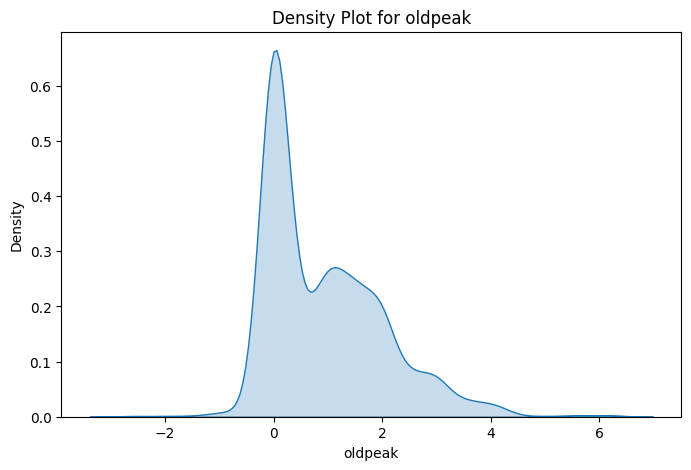

In [ ]:
# Step 9: Density Plot for Individual Numerical Features
print("Step 9: Creating Density Plot for Individual Numerical Features")
numerical_features = ['age', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak']
for feature in numerical_features:
    print(f"Density Plot for {feature}")
    plt.figure(figsize=(8, 5))
    sns.kdeplot(df[feature], shade=True)
    plt.title(f'Density Plot for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.show()


Step 10: Checking for Class Imbalance
Class Distribution in the Target Variable:


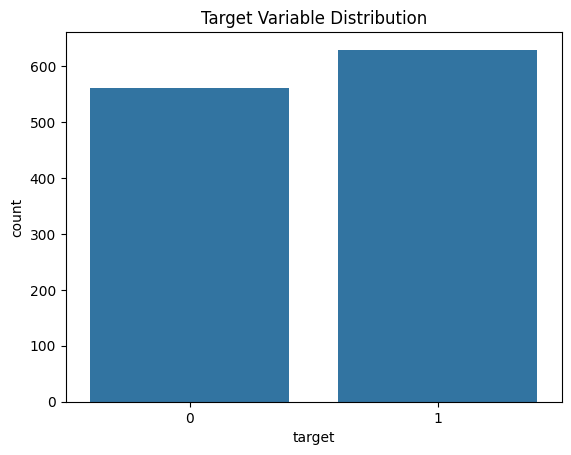

Class Imbalance: 
target
1    629
0    561
Name: count, dtype: int64


In [ ]:
# Step 10: Check for Class Imbalance
print("Step 10: Checking for Class Imbalance")
print("Class Distribution in the Target Variable:")
sns.countplot(x='target', data=df)
plt.title('Target Variable Distribution')
plt.show()

class_counts = df['target'].value_counts()
print(f"Class Imbalance: \n{class_counts}")


In [ ]:
# Step 17: Feature Scaling
print("Step 17: Feature Scaling")

# Select numerical features for scaling
numerical_columns = ['age', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak']

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply scaling to numerical columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

print("Feature Scaling Applied:")
print(df[numerical_columns].head())  # Display scaled numerical features

Step 17: Feature Scaling
Feature Scaling Applied:
        age  resting bp s  cholesterol  max heart rate   oldpeak
0 -1.466728      0.427328     0.775674        1.265039 -0.849792
1 -0.504600      1.516587    -0.299512        0.637758  0.071119
2 -1.787437     -0.117301     0.716489       -1.636136 -0.849792
3 -0.611503      0.318402     0.035867       -1.244085  0.531575
4  0.029915      0.971958    -0.151550       -0.695214 -0.849792


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Define X and y if not defined yet
X = df.drop('target', axis=1)  # Drop the target column from features
y = df['target']               # Target variable

# Step 20: Performing k-Fold Cross-Validation
print("Step 20: Performing k-Fold Cross-Validation")

# Define the number of folds
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize variables to track performance
fold = 1
accuracies = []

for train_index, test_index in kf.split(X):
    print(f"Fold {fold}:")
    # Splitting the data into training and validation sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Print the shapes for this fold
    print(f"Training Set Shape: {X_train.shape}")
    print(f"Testing Set Shape: {X_test.shape}")

    # Example model (e.g., Logistic Regression, replace with your model)
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Validate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for Fold {fold}: {accuracy}")
    accuracies.append(accuracy)

    fold += 1

# Calculate and print the average accuracy across all folds
average_accuracy = sum(accuracies) / k
print(f"Average Accuracy across {k} folds: {average_accuracy}")


Step 20: Performing k-Fold Cross-Validation
Fold 1:
Training Set Shape: (1071, 11)
Testing Set Shape: (119, 11)
Accuracy for Fold 1: 0.8991596638655462
Fold 2:
Training Set Shape: (1071, 11)
Testing Set Shape: (119, 11)
Accuracy for Fold 2: 0.8151260504201681
Fold 3:
Training Set Shape: (1071, 11)
Testing Set Shape: (119, 11)
Accuracy for Fold 3: 0.8571428571428571
Fold 4:
Training Set Shape: (1071, 11)
Testing Set Shape: (119, 11)
Accuracy for Fold 4: 0.8739495798319328
Fold 5:
Training Set Shape: (1071, 11)
Testing Set Shape: (119, 11)
Accuracy for Fold 5: 0.8067226890756303
Fold 6:
Training Set Shape: (1071, 11)
Testing Set Shape: (119, 11)
Accuracy for Fold 6: 0.8403361344537815
Fold 7:
Training Set Shape: (1071, 11)
Testing Set Shape: (119, 11)
Accuracy for Fold 7: 0.7983193277310925
Fold 8:
Training Set Shape: (1071, 11)
Testing Set Shape: (119, 11)
Accuracy for Fold 8: 0.8151260504201681
Fold 9:
Training Set Shape: (1071, 11)
Testing Set Shape: (119, 11)
Accuracy for Fold 9: 0.7

In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

# Step 21: Applying PCA for Dimensionality Reduction
print("Step 21: Applying PCA for Dimensionality Reduction")

# Define the number of folds
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

fold = 1

for train_index, test_index in kf.split(X):
    print(f"Fold {fold}:")
    # Splitting the data into training and validation sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]

    # Apply PCA
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Print the number of features before and after PCA
    print(f"Original number of features: {X_train.shape[1]}")
    print(f"Reduced number of features after PCA: {X_train_pca.shape[1]}")

    fold += 1


Step 21: Applying PCA for Dimensionality Reduction
Fold 1:
Original number of features: 11
Reduced number of features after PCA: 9
Fold 2:
Original number of features: 11
Reduced number of features after PCA: 9
Fold 3:
Original number of features: 11
Reduced number of features after PCA: 9
Fold 4:
Original number of features: 11
Reduced number of features after PCA: 9
Fold 5:
Original number of features: 11
Reduced number of features after PCA: 9
Fold 6:
Original number of features: 11
Reduced number of features after PCA: 9
Fold 7:
Original number of features: 11
Reduced number of features after PCA: 9
Fold 8:
Original number of features: 11
Reduced number of features after PCA: 9
Fold 9:
Original number of features: 11
Reduced number of features after PCA: 9
Fold 10:
Original number of features: 11
Reduced number of features after PCA: 9


Step 22: Model Selection, Hyperparameter Tuning, and Tracking Run Time
Training RandomForest...
Best Parameters for RandomForest: {'n_estimators': 100, 'max_depth': None}
Run Time for RandomForest: 15.38 seconds
Accuracy: 0.9076, ROC-AUC: 0.9489
Training GradientBoosting...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for GradientBoosting: {'n_estimators': 100, 'learning_rate': 0.2}
Run Time for GradientBoosting: 6.64 seconds
Accuracy: 0.9160, ROC-AUC: 0.9298
Training XGBoost...
An error occurred with XGBoost: 'super' object has no attribute '__sklearn_tags__'
Training LightGBM...
[LightGBM] [Info] Number of positive: 383, number of negative: 331
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2145
[LightGBM] [Info] Number of data points in the train set: 714, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.536415 -> initscore=0.145917
[LightGBM] [Info] Start training from score 0.145917
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tag

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 382, number of negative: 332
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2138
[LightGBM] [Info] Number of data points in the train set: 714,

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

[LightGBM] [Info] Number of positive: 382, number of negative: 332
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2138
[LightGBM] [Info] Number of data points in the train set: 714, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.535014 -> initscore=0.140286
[LightGBM] [Info] Start training from score 0.140286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 383, number of negative: 331
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2138
[LightGBM] [Info] Number of data points in the train set: 714, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.536415 -> initscore=0.145917
[LightGBM] [Info] Start training from score 0.145917
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriat

Best Parameters for LightGBM: {'n_estimators': 100, 'learning_rate': 0.1}
Run Time for LightGBM: 1.52 seconds
Accuracy: 0.8992, ROC-AUC: 0.9491
Training CatBoost...
Best Parameters for CatBoost: {'learning_rate': 0.1, 'iterations': 100}
Run Time for CatBoost: 3.00 seconds
Accuracy: 0.8403, ROC-AUC: 0.9247
Training SVM...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for SVM: {'gamma': 'auto', 'C': 10}
Run Time for SVM: 2.76 seconds
Accuracy: 0.8487, ROC-AUC: 0.9085
Training MLP...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perc

Best Parameters for MLP: {'hidden_layer_sizes': (20,), 'activation': 'tanh'}
Run Time for MLP: 23.17 seconds
Accuracy: 0.8487, ROC-AUC: 0.9188
XGBoost model is not available in best_models. Please check for errors in training.

Model Training Summary:
RandomForest: Run Time: 15.38s, Accuracy: 0.9076
GradientBoosting: Run Time: 6.64s, Accuracy: 0.9160
LightGBM: Run Time: 1.52s, Accuracy: 0.8992
CatBoost: Run Time: 3.00s, Accuracy: 0.8403
SVM: Run Time: 2.76s, Accuracy: 0.8487
MLP: Run Time: 23.17s, Accuracy: 0.8487

Step 23: Creating Voting Classifier and Tracking Run Time


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 574, number of negative: 497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2294
[LightGBM] [Info] Number of data points in the train set: 1071, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.535948 -> initscore=0.144039
[LightGBM] [Info] Start training from score 0.144039


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Voting Classifier Training Time: 9.13 seconds
Voting Classifier Accuracy: 0.9076, ROC-AUC: 0.9409

Voting Classifier Results:
Accuracy: 0.9076
Precision: 0.9231
Sensitivity (Recall): 0.8727
Specificity: 0.9375
F1 Score: 0.8972


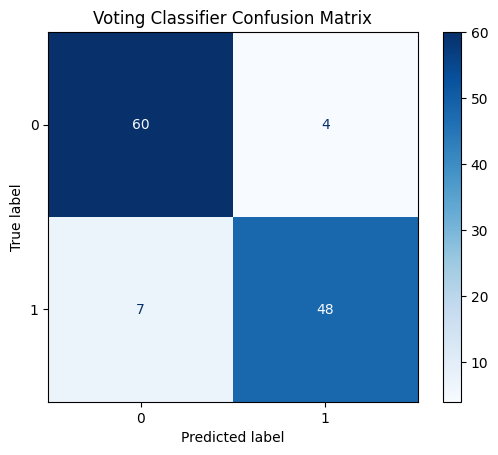


Step 26: Model Evaluation Metrics for All Models

RandomForest Model Performance:
Accuracy: 0.9076
Precision: 0.9074
Sensitivity (Recall): 0.8909
Specificity: 0.9219
F1 Score: 0.8991


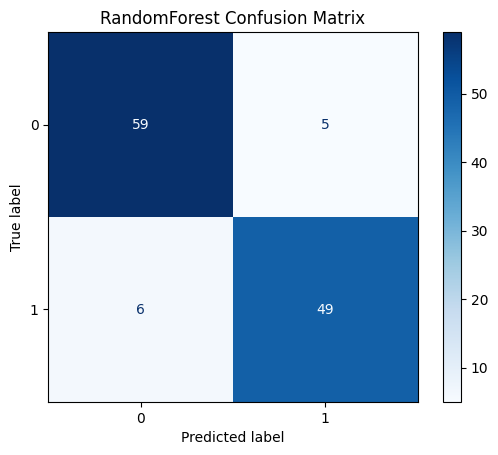


GradientBoosting Model Performance:
Accuracy: 0.9160
Precision: 0.9245
Sensitivity (Recall): 0.8909
Specificity: 0.9375
F1 Score: 0.9074


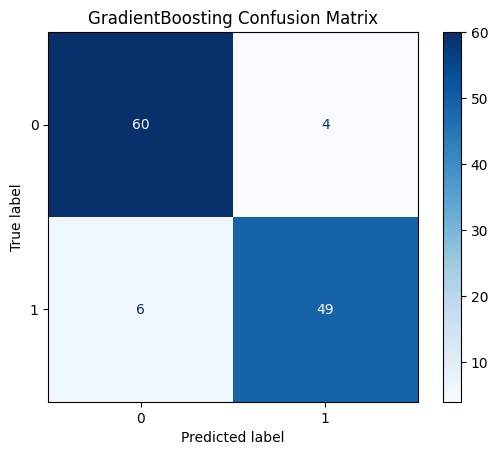

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



LightGBM Model Performance:
Accuracy: 0.8992
Precision: 0.8772
Sensitivity (Recall): 0.9091
Specificity: 0.8906
F1 Score: 0.8929


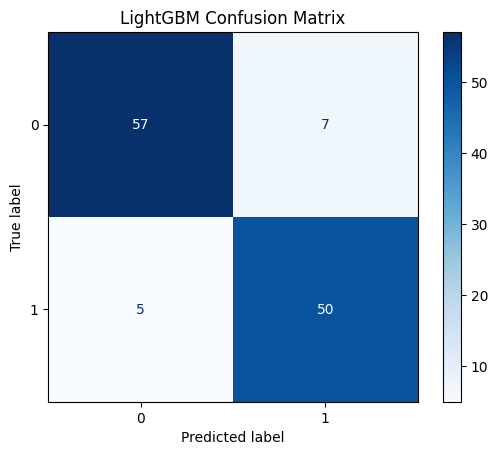


CatBoost Model Performance:
Accuracy: 0.8403
Precision: 0.8913
Sensitivity (Recall): 0.7455
Specificity: 0.9219
F1 Score: 0.8119


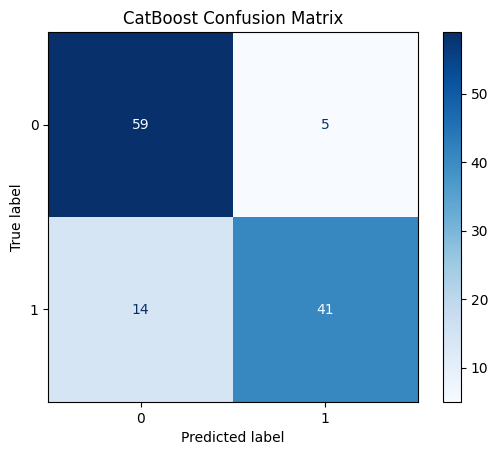


SVM Model Performance:
Accuracy: 0.8487
Precision: 0.8364
Sensitivity (Recall): 0.8364
Specificity: 0.8594
F1 Score: 0.8364


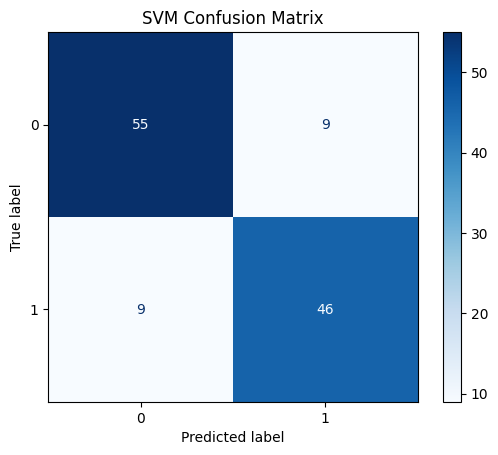


MLP Model Performance:
Accuracy: 0.8487
Precision: 0.8776
Sensitivity (Recall): 0.7818
Specificity: 0.9062
F1 Score: 0.8269


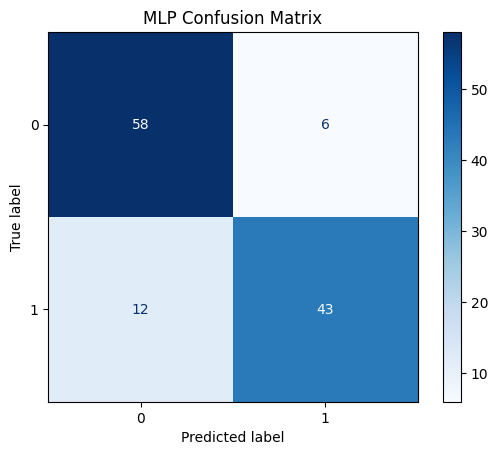


Note: Sensitivity (recall) and specificity are crucial for balanced predictions in heart disease diagnosis.


In [ ]:
# Import necessary libraries
import time
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Define models and hyperparameters
models = {
    'RandomForest': (
        RandomForestClassifier(),
        {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}
    ),
    'GradientBoosting': (
        GradientBoostingClassifier(),
        {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 0.2]}
    ),
    'XGBoost': (
        XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0),
        {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
    ),
    'LightGBM': (
        LGBMClassifier(),
        {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
    ),
    'CatBoost': (
        CatBoostClassifier(silent=True),
        {'iterations': [50, 100], 'learning_rate': [0.01, 0.1]}
    ),
    'SVM': (
        SVC(probability=True),
        {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
    ),
    'MLP': (
        MLPClassifier(max_iter=500),
        {'hidden_layer_sizes': [(10,), (20,), (30,)], 'activation': ['tanh', 'relu']}
    )
}

# Variables to track the best models, metrics, and run times
best_models = {}
run_times = {}
metrics = {}

# Step 22: Model Selection, Hyperparameter Tuning, and Tracking Run Time
print("Step 22: Model Selection, Hyperparameter Tuning, and Tracking Run Time")

for model_name, (model, params) in models.items():
    try:
        print(f"Training {model_name}...")
        start_time = time.time()

        # Randomized Search CV for hyperparameter tuning
        search = RandomizedSearchCV(
            model, params, n_iter=10, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
            verbose=0, random_state=42, scoring='roc_auc'
        )
        search.fit(X_train_pca, y_train)

        elapsed_time = time.time() - start_time
        best_model = search.best_estimator_
        best_models[model_name] = best_model
        run_times[model_name] = elapsed_time

        y_pred = best_model.predict(X_test_pca)
        y_pred_prob = best_model.predict_proba(X_test_pca)[:, 1] if hasattr(best_model, 'predict_proba') else None

        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_prob) if y_pred_prob is not None else None

        metrics[model_name] = {'accuracy': acc, 'roc_auc': auc}
        print(f"Best Parameters for {model_name}: {search.best_params_}")
        print(f"Run Time for {model_name}: {elapsed_time:.2f} seconds")
        print(f"Accuracy: {acc:.4f}, ROC-AUC: {auc:.4f}" if auc else f"Accuracy: {acc:.4f}")

    except Exception as e:
        print(f"An error occurred with {model_name}: {e}")

# Ensure XGBoost is available in best_models
if 'XGBoost' not in best_models:
    print("XGBoost model is not available in best_models. Please check for errors in training.")
else:
    print("XGBoost model has been successfully trained and added to best_models.")
    # Debugging: Print the model and check if it's trained
    print("XGBoost Model: ", best_models['XGBoost'])

# Print model metrics, including XGBoost, if it is successfully trained
print("\nModel Training Summary:")
for model_name, run_time in run_times.items():
    print(f"{model_name}: Run Time: {run_time:.2f}s, Accuracy: {metrics[model_name]['accuracy']:.4f}")

# Step 23: Creating Voting Classifier and Tracking Run Time
print("\nStep 23: Creating Voting Classifier and Tracking Run Time")
estimators = [(name, model) for name, model in best_models.items()]
voting_clf = VotingClassifier(estimators=estimators, voting='soft')

start_time = time.time()
voting_clf.fit(X_train_pca, y_train)
voting_elapsed_time = time.time() - start_time

voting_acc = accuracy_score(y_test, voting_clf.predict(X_test_pca))
voting_auc = roc_auc_score(y_test, voting_clf.predict_proba(X_test_pca)[:, 1])
print(f"Voting Classifier Training Time: {voting_elapsed_time:.2f} seconds")
print(f"Voting Classifier Accuracy: {voting_acc:.4f}, ROC-AUC: {voting_auc:.4f}")

# Step 24: Voting Classifier Performance
print("\nVoting Classifier Results:")
y_pred_voting = voting_clf.predict(X_test_pca)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_voting).ravel()
precision_voting = precision_score(y_test, y_pred_voting)
recall_voting = tp / (tp + fn)
specificity_voting = tn / (tn + fp)
f1_voting = f1_score(y_test, y_pred_voting)
print(f"Accuracy: {voting_acc:.4f}")
print(f"Precision: {precision_voting:.4f}")
print(f"Sensitivity (Recall): {recall_voting:.4f}")
print(f"Specificity: {specificity_voting:.4f}")
print(f"F1 Score: {f1_voting:.4f}")

disp_voting = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_voting), display_labels=[0, 1])
disp_voting.plot(cmap='Blues')
plt.title('Voting Classifier Confusion Matrix')
plt.show()

# Step 26: Model Evaluation Metrics for All Models
print("\nStep 26: Model Evaluation Metrics for All Models")

for model_name, model in best_models.items():
    y_pred = model.predict(X_test_pca)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = f1_score(y_test, y_pred)
    print(f"\n{model_name} Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Sensitivity (Recall): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

print("\nNote: Sensitivity (recall) and specificity are crucial for balanced predictions in heart disease diagnosis.")


Training XGBoost model with default parameters...
XGBoost Model Results:
Training Time: 0.53 seconds
Accuracy: 0.9244
ROC-AUC: 0.9497
Precision: 0.9259
Sensitivity (Recall): 0.9091
Specificity: 0.9375
F1 Score: 0.9174


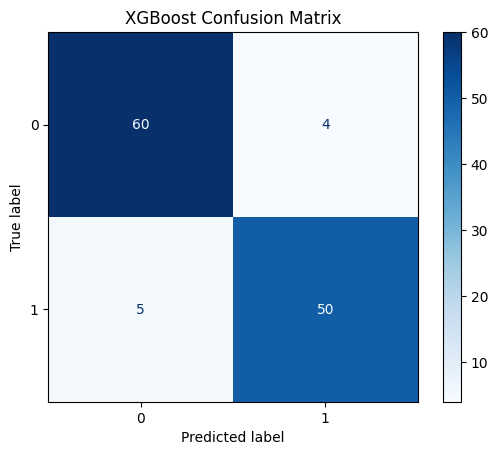

In [ ]:
# Import necessary libraries
import time
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Train XGBoost with default parameters
print("Training XGBoost model with default parameters...")

# Record the start time
start_time = time.time()

# Initialize the XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)

# Fit the model on the training data (assuming X_train_pca and y_train are defined)
xgb.fit(X_train_pca, y_train)

# Calculate training time
elapsed_time = time.time() - start_time

# Make predictions
y_pred = xgb.predict(X_test_pca)
y_pred_prob = xgb.predict_proba(X_test_pca)[:, 1]  # Assuming binary classification

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

# Print results
print(f"XGBoost Model Results:")
print(f"Training Time: {elapsed_time:.2f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {auc:.4f}")

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision:.4f}")
print(f"Sensitivity (Recall): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.show()


Step 27: Model Evaluation and ROC Curves

RandomForest Model Metrics:
AUC: 0.95
Sensitivity (True Positive Rate): 0.89
Specificity (True Negative Rate): 0.92

GradientBoosting Model Metrics:
AUC: 0.93
Sensitivity (True Positive Rate): 0.89
Specificity (True Negative Rate): 0.94

LightGBM Model Metrics:
AUC: 0.95
Sensitivity (True Positive Rate): 0.91
Specificity (True Negative Rate): 0.89

CatBoost Model Metrics:
AUC: 0.92
Sensitivity (True Positive Rate): 0.75
Specificity (True Negative Rate): 0.92

SVM Model Metrics:
AUC: 0.91
Sensitivity (True Positive Rate): 0.84
Specificity (True Negative Rate): 0.86

MLP Model Metrics:
AUC: 0.92
Sensitivity (True Positive Rate): 0.78
Specificity (True Negative Rate): 0.91


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Voting Classifier Metrics:
AUC: 0.94
Sensitivity (True Positive Rate): 0.87
Specificity (True Negative Rate): 0.94

XGBoost Model Metrics:
AUC: 0.95
Sensitivity (True Positive Rate): 0.91
Specificity (True Negative Rate): 0.94


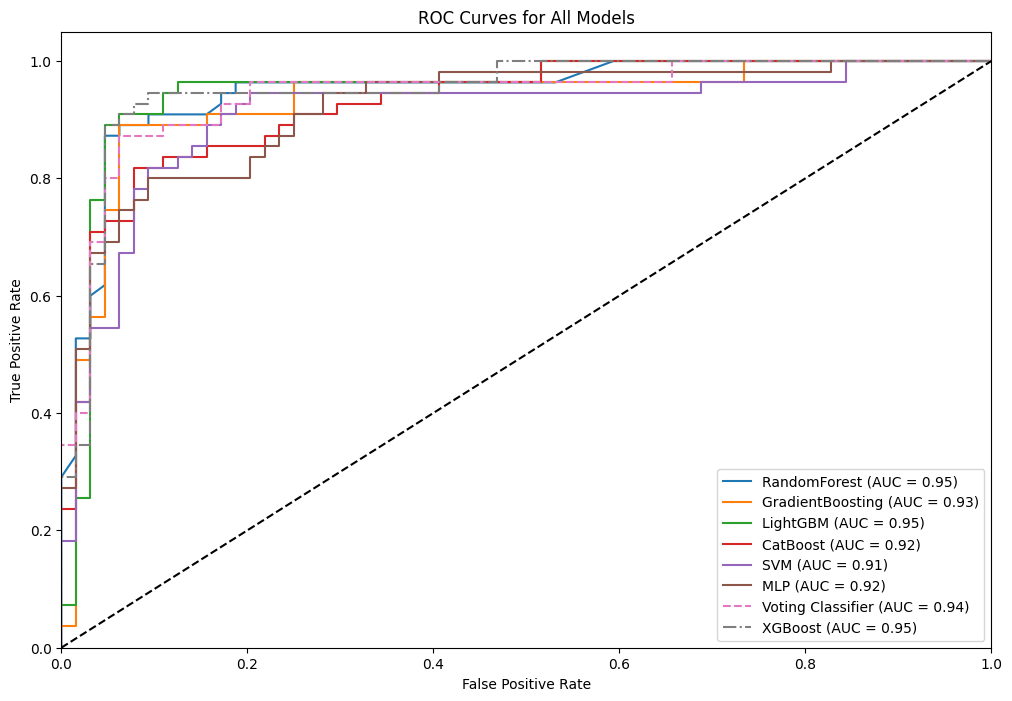

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import xgboost as xgb

# Assuming X_train_pca and y_train are your training features and labels
# If you're using PCA-transformed data, ensure that the following variables are defined:
# X_train_pca, X_test_pca, y_train, y_test

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier()

# Train the model on the training data
xgb_model.fit(X_train_pca, y_train)

print("Step 27: Model Evaluation and ROC Curves")

# Plot ROC Curve for each model
plt.figure(figsize=(12, 8))

# Iterate over each model in best_models to evaluate and plot ROC curves
for model_name, model in best_models.items():
    # Get predicted probabilities for the positive class
    y_pred_prob = model.predict_proba(X_test_pca)[:, 1]

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Compute AUC (Area Under the Curve)
    auc_value = auc(fpr, tpr)

    # Calculate confusion matrix and specificity
    y_pred = model.predict(X_test_pca)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)  # True Positive Rate
    specificity = tn / (tn + fp)  # True Negative Rate

    # Print sensitivity and specificity
    print(f"\n{model_name} Model Metrics:")
    print(f"AUC: {auc_value:.2f}")
    print(f"Sensitivity (True Positive Rate): {sensitivity:.2f}")
    print(f"Specificity (True Negative Rate): {specificity:.2f}")

    # Plot ROC curve for the model
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_value:.2f})')

# Evaluate and plot ROC for Voting Classifier
y_pred_prob_voting = voting_clf.predict_proba(X_test_pca)[:, 1]  # Get predicted probabilities for the positive class
fpr_voting, tpr_voting, _ = roc_curve(y_test, y_pred_prob_voting)  # Compute ROC curve
auc_value_voting = auc(fpr_voting, tpr_voting)  # Compute AUC for the Voting Classifier

# Calculate confusion matrix and specificity for Voting Classifier
y_pred_voting = voting_clf.predict(X_test_pca)
tn_voting, fp_voting, fn_voting, tp_voting = confusion_matrix(y_test, y_pred_voting).ravel()
sensitivity_voting = tp_voting / (tp_voting + fn_voting)  # True Positive Rate
specificity_voting = tn_voting / (tn_voting + fp_voting)  # True Negative Rate

# Print sensitivity and specificity for Voting Classifier
print("\nVoting Classifier Metrics:")
print(f"AUC: {auc_value_voting:.2f}")
print(f"Sensitivity (True Positive Rate): {sensitivity_voting:.2f}")
print(f"Specificity (True Negative Rate): {specificity_voting:.2f}")

# Plot ROC curve for Voting Classifier
plt.plot(fpr_voting, tpr_voting, label=f'Voting Classifier (AUC = {auc_value_voting:.2f})', linestyle='--')

# Add ROC Curve for XGBoost model
y_pred_prob_xgb = xgb_model.predict_proba(X_test_pca)[:, 1]  # Get predicted probabilities for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_prob_xgb)  # Compute ROC curve for XGBoost
auc_value_xgb = auc(fpr_xgb, tpr_xgb)  # Compute AUC for XGBoost

# Calculate confusion matrix and specificity for XGBoost
y_pred_xgb = xgb_model.predict(X_test_pca)
tn_xgb, fp_xgb, fn_xgb, tp_xgb = confusion_matrix(y_test, y_pred_xgb).ravel()
sensitivity_xgb = tp_xgb / (tp_xgb + fn_xgb)  # True Positive Rate
specificity_xgb = tn_xgb / (tn_xgb + fp_xgb)  # True Negative Rate

# Print sensitivity and specificity for XGBoost
print("\nXGBoost Model Metrics:")
print(f"AUC: {auc_value_xgb:.2f}")
print(f"Sensitivity (True Positive Rate): {sensitivity_xgb:.2f}")
print(f"Specificity (True Negative Rate): {specificity_xgb:.2f}")

# Plot ROC curve for XGBoost
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_value_xgb:.2f})', linestyle='-.')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random guessing line)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc="lower right")
plt.show()
